In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several he>lpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# SETUP

In [2]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow.keras.optimizers.experimental import AdamW # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

# DOWNLOAD THE IMDB DATASET

In [3]:
#Get dataset url and download the dataset.
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
dataset = tf.keras.utils.get_file("aclImdb_v1.tar.gz",url,untar = True,cache_dir ='.',cache_subdir ='')
#Define the pats of dataset and train directory.
dataset_dir = os.path.join(os.path.dirname(dataset),"aclImdb")
train_dir = os.path.join(dataset_dir,"train")
#Remove unused folders to make it easier to load the data.
remove_dir = os.path.join(train_dir,"unsup")
shutil.rmtree(remove_dir)

84125825/84125825 [==============================] - 2s 0us/step


In [4]:
#The IMDB dataset has already divided into train and test.
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42
#Create train dataset.
raw_train_ds = tf.keras.utils.text_dataset_from_directory("aclImdb/train",batch_size = batch_size,
                                                     validation_split = 0.2,subset = "training",
                                                     seed = seed)
class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size = AUTOTUNE)
#Create validation dataset.
val_ds = tf.keras.utils.text_dataset_from_directory("aclImdb/train",batch_size = batch_size,
                                                   validation_split = 0.2,subset = "validation",
                                                   seed = seed)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)
#Create test dataset
test_ds = tf.keras.utils.text_dataset_from_directory("aclImdb/test",batch_size = batch_size)
test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [5]:
#Some reviews.Get batch_sized amount of data with take method.
for text_batch,label_batch in train_ds.take(1):
    for i in range(3):
        review = text_batch.numpy()[i]
        print(f"Review : {review}")
        label = label_batch.numpy()[i]
        print(f"Label : {label} ({class_names[label]})")

Review : b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label : 0 (neg)
Review : b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as th

# CHOOSE A BERT MODEL TO FINE-TUNE

In [6]:
#You can pick your BERT MODEL from tensorflow hub. 
tfhub_handle_encoder = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/2"
tfhub_handle_preprocess = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/2
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [7]:
#Define preprocess model to tokenize texts with respect to BERT MODEL.
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [10]:
#See properties on example text.
test_text = ["This is the worst movie i have ever seen."]
text_preprocessed = bert_preprocess_model(test_text)
print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_mask', 'input_type_ids', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 1996 5409 3185 1045 2031 2412 2464 1012  102]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


# DEFINE YOUR MODEL

In [11]:
def build_classifier_model():
    #Get text input and preprocess it.
    text_input = tf.keras.layers.Input(shape = (),dtype = tf.string,name = "text")
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess,name = "preprocessing")
    encoder_inputs = preprocessing_layer(text_input)
    #Use encoder to apply BERT MODEL.
    encoder = hub.KerasLayer(tfhub_handle_encoder,trainable = True,name = "BERT_encoder")
    outputs = encoder(encoder_inputs)
    #You can think of a pooled_output as a embedding for the entire movie_review.
    net = outputs["pooled_output"]
    #Droupout and output layers.
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1,activation = None,name = "classifier")(net)
    return tf.keras.Model(text_input,net)
    

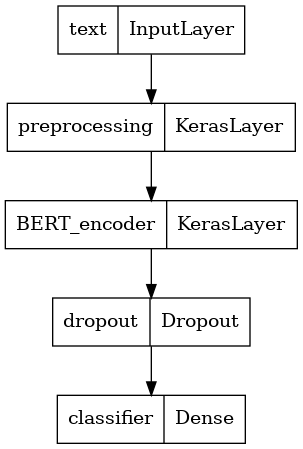

In [12]:
#Assign classifier model.
classifier_model = build_classifier_model()
#Look at the model structure.
tf.keras.utils.plot_model(classifier_model)

# MODEL TRAINING

In [13]:
#Use binary crossentropy loss because of this is a binary classification problem and
#model outputs a probability.
loss = tf.keras.losses.BinaryCrossentropy(from_logits = True)
metrics = tf.metrics.BinaryAccuracy()

In [ ]:
!pip install tf-models-official

In [16]:
from official.nlp import optimization
#Optimizer,use the AdamW optimizer same as BERT.
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                      num_train_steps=num_train_steps,
                      num_warmup_steps=num_warmup_steps)

In [17]:
#Compile the model
classifier_model.compile(optimizer = optimizer,loss = loss,metrics = metrics)

In [18]:
print(f"Training model : {tfhub_handle_encoder}")
history = classifier_model.fit(x = train_ds,validation_data = val_ds,epochs = epochs)

Training model : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/2
Epoch 1/5
625/625 [==============================] - 340s 517ms/step - loss: 0.4459 - binary_accuracy: 0.7738 - val_loss: 0.3666 - val_binary_accuracy: 0.8488
Epoch 2/5
625/625 [==============================] - 321s 513ms/step - loss: 0.2777 - binary_accuracy: 0.8809 - val_loss: 0.3908 - val_binary_accuracy: 0.8576
Epoch 3/5
625/625 [==============================] - 320s 513ms/step - loss: 0.1823 - binary_accuracy: 0.9298 - val_loss: 0.4394 - val_binary_accuracy: 0.8574
Epoch 4/5
625/625 [==============================] - 320s 512ms/step - loss: 0.1157 - binary_accuracy: 0.9615 - val_loss: 0.5857 - val_binary_accuracy: 0.8514
Epoch 5/5
625/625 [==============================] - 320s 511ms/step - loss: 0.0819 - binary_accuracy: 0.9736 - val_loss: 0.6061 - val_binary_accuracy: 0.8618


**Evaluate the model**

In [19]:
loss,accuracy = classifier_model.evaluate(test_ds)
print(f"Loss : {loss} , Accuracy : {accuracy}")

782/782 [==============================] - 155s 198ms/step - loss: 0.5782 - binary_accuracy: 0.8656
Loss : 0.5781943202018738 , Accuracy : 0.8655999898910522


**Plot history**

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


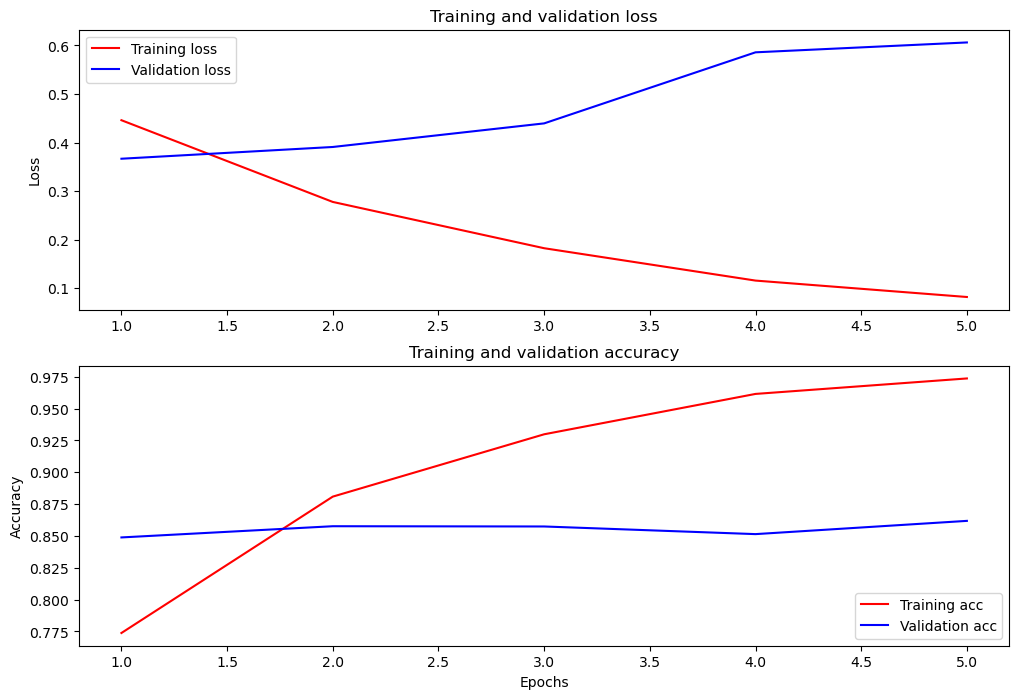

In [20]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(12, 8))

#For losses
plt.subplot(2, 1, 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('Loss')
plt.legend()
#For accuracy
plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

# SAVE MODEL

In [21]:
dataset_name = "imdb"
saved_model_path = "./{}_bert".format(dataset_name.replace("/","_"))
classifier_model.save(saved_model_path,include_optimizer = False)


In [22]:
saved_model_path

'./imdb_bert'

# EXAMPLES TO PREDICT

In [23]:
#Get saved model
model_saved = tf.saved_model.load(saved_model_path)

In [24]:
#Function to classify preds as pos and negative.
def decode_probs(preds):
    results = []
    for i in range(len(preds)):
        if preds.numpy()[i] >= 0.5:
            results.append("positive")
        else:
            results.append("negative")
    return results

In [25]:
#Write some reviews.
examples = ["What a terrible movie!","It was great.","AWESOME","It didnt work"]
preds = tf.sigmoid(tf.constant(model_saved(examples)))
print(decode_probs(preds))

['negative', 'positive', 'positive', 'negative']


In [26]:
#You can change n if you want different amount of examples.
n = 3
reviews = []
labels = []
#Pred reviews from test dataset.
for text_batch,label_batch in test_ds.take(1):
    for i in range(n):
        text = text_batch.numpy()[i].decode("utf-8")
        label = np.array([label_batch.numpy()[i]])
        #Add text and labels to lists.
        reviews.append(text)
        labels.append(label)

pred = tf.sigmoid(model_saved(tf.constant(reviews)))
for i in range(len(pred)):
    print(f"Review : {reviews[i]}")
    print(f"Prediction : {decode_probs(pred[i])} Real : {decode_probs(tf.constant(labels[i]))}")
    print("\n\n")

Review : Originally supposed to be just a part of a huge epic The Year 1905 depicting the Revolution of 1905, Potemkin is the story of the mutiny of the crew of the Potemkin in Odessa harbor. The film opens with the crew protesting maggoty meat and the captain ordering the execution of the dissidents. An uprising takes place during which the revolutionary leader is killed. This crewman is taken to the shore to lie in state. When the townspeople gather on a huge flight of steps overlooking the harbor, czarist troops appear and march down the steps breaking up the crowd. A naval squadron is sent to retake the Potemkin but at the moment when the ships come into range, their crews allow the mutineers to pass through. Eisenstein's non-historically accurate ending is open-ended thus indicating that this was the seed of the later Bolshevik revolution that would bloom in Russia. The film is broken into five parts: Men and Maggots, Drama on the Quarterdeck, An Appeal from the Dead, The Odessa S